In [1]:
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
from functions.helper_functions import (
    calculate_bayesian_posterior_pvalue, 
    verify,
    theano_normalize, 
    softmax
)
from functions.models_fixedarray import calculate_logp_data


In [20]:
# This is the location of the traces in Fausto's system
# but they are too large for github.
folder_pilot_traces = '../arglang_model_fitting/pilot_models_traces/'
# location of raw data in Fausto's system
# but if you've cloned the repo you can just run
# the cell below to load the cleaned data directly
folder_pilot_data = '../arglang_exp/data_pilot/data_raw.csv'
folder_pilot_cleaned_data = './data/data_pilot/'

In [45]:
if exists(folder_pilot_data):
    pilot_data = get_and_clean_data_exp1(pathdata=folder_pilot_data)
    raw_data, data, possible_observations, possible_utterances = pilot_data
    data.to_csv(join(folder_pilot_cleaned_data, 'cleaned_data.csv'), index=False)
    pd.DataFrame(possible_observations).to_csv(join(folder_pilot_cleaned_data, 'obs.csv'), index=False)
    pd.DataFrame(possible_utterances).to_csv(join(folder_pilot_cleaned_data, 'utts.csv'), index=False)
else:
    # read the pre-cleaned data
    data = pd.read_csv(join(folder_pilot_cleaned_data, 'cleaned_data.csv'))
    possible_observations = pd.read_csv(join(folder_pilot_cleaned_data, 'obs.csv')).to_numpy()
    possible_utterances = pd.read_csv(join(folder_pilot_cleaned_data, 'utts.csv')).to_numpy()

a total of 200 of the raw datapoints are test trials. This leaves 20 potential datapoints per participant.
8  were excluded because incompletely recorded
4  of the participants were excluded as they gave more than 4 false responses
52  of the observations in the included participants were excluded because literally false


/mnt/c/Users/faust/OneDrive - UvA/research_projects/2022_arglang/arglang_modelling/functions/data_functions.py:82: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  str(len(data[raw_data['trial_name'] != 'main_trials'])) +
/mnt/c/Users/faust/OneDrive - UvA/research_projects/2022_arglang/arglang_modelling/functions/data_functions.py:87: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,'condition'] = (data.condition == 'high').astype(int)


# Basic model in Numpy

Summary of the model:

- This is a production model, i.e. calculates the probability of each possible utterance given the parameters and observations
- In particular, there are 4 x 4 x 2 possible utterances
- Possible quantifiers: none, some, most, all
- There are 20 possible observations (can be seen with `raw_data['row_number'].unique()`)
    - Note that since the rows are always in decreasing order in the experiment, I don't need to worry about equivalent observations
- Need to calculate: 
    - p( utterance | gamma ): marginalized across possible observations
    - p( state | utterance )

In [883]:
# this function computes the loglikelihood
# of the data for a combination of input parameters
calculate_logp_data(data, 1, 0.5, possible_observations, possible_utterances, True)

array([-9.49218059e-02, -4.85873522e-02, -1.98953602e+00, ...,
       -1.68279487e+00, -1.06357412e-02, -1.41322614e+01])

In [220]:
# evaluate the loglikelihood for a grid of parameters
# and plot the results.
alphas, betas = np.mgrid[0.1:5:20j, 0.8:1:20j]
loglik_data = np.array([
    functions.calculate_logp_data(
        data, a, b, possible_observations, 
        possible_utterances, like_cogsci_paper=True
    ).sum()
    for a, b in zip(alphas.flatten(), betas.flatten())
]).reshape(*alphas.shape)

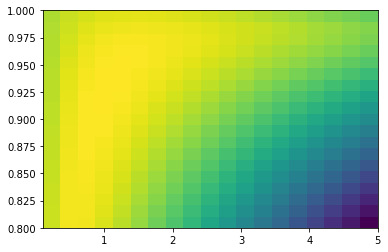

In [224]:
plt.pcolor(alphas, betas, loglik_data)

# Test Bayesian p-value function

## Test on accurate model

In [12]:
ys_np_f = pm.Normal.dist(mu=0, sigma=1.).random
ys_np = np.array([ys_np_f() for _ in range(100)])

In [13]:
with pm.Model() as testmodel:
    ys = pm.Data('observed', ys_np)
    mu = pm.Normal('mu', mu=0, sigma=1)
    pm.Normal('ys', mu=mu, observed=ys)
    trace = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [14]:
with testmodel:
    pps_test = pm.sample_posterior_predictive(trace)

In [15]:
pps_test = pps_test['ys']

In [16]:
bayesian_pvalue_test = calculate_bayesian_posterior_pvalue(
    trace, 
    pps_test, 
    testmodel,
    # pointwise=True,
    # return_full=True
)

0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 

In [17]:
bayesian_pvalue_test

0.13175

sns.kdeplot(bayesian_pvalue_test, clip=[0,1])

```
# Kolmogorov-Smirnov test to check
# null hypothesis of continuous uniform distribution
sp.stats.kstest(bayesian_pvalue_test, cdf=sp.stats.uniform.cdf)
```

## Test the function on an inaccurate model

In [20]:
ys_np_f = pm.Normal.dist(mu=0, sigma=3.).random
ys_np = np.array([ys_np_f() for _ in range(100)])

In [21]:
with pm.Model() as testmodel:
    ys = pm.Data('observed', ys_np)
    mu = pm.Normal('mu', mu=0, sigma=1)
    pm.Normal('ys', mu=mu, observed=ys)
    trace = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [22]:
with testmodel:
    pps_test = pm.fast_sample_posterior_predictive(trace)

In [23]:
pps_test = pps_test['ys']

In [24]:
bayesian_pvalue_test = calculate_bayesian_posterior_pvalue(
    trace, 
    pps_test, 
    testmodel,
    # pointwise=True,
    # return_full=True
)

0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 

In [25]:
bayesian_pvalue_test

0.0

In [26]:
bayesian_pvalue_test_pointwise = calculate_bayesian_posterior_pvalue(
    trace, 
    pps_test, 
    testmodel,
    pointwise=True,
    # return_full=True
)

0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 

<AxesSubplot:ylabel='Density'>

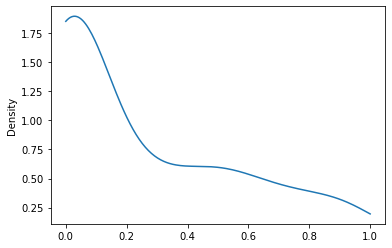

In [27]:
sns.kdeplot(bayesian_pvalue_test_pointwise, clip=[0,1])

In [28]:
# Kolmogorov-Smirnov test to check
# null hypothesis of continuous uniform distribution
sp.stats.kstest(bayesian_pvalue_test_pointwise, cdf=sp.stats.uniform.cdf)

KstestResult(statistic=0.43699999999999994, pvalue=6.824278889148651e-18)

# Define trials for the variable array size conditions

In [1]:
from itertools import product

What states should be included in the experiment, for a given number of students and questions? 
- One state for each element of the partition induced by the set of signals.
- I am just almost bruteforce calculating the partition and then hand-picking observations

In [2]:
def check_minimal(possible_observations, possible_utterances, n_answers, n_students):
    
    # exclude the false responses from the data
    utterance_observation_compatibility = np.stack([
        verify(*a, possible_observations, n_answers, n_students)
        for a in possible_utterances
    ])
    # check that all and only the diagonal elements are True
    same_truth_profile = (
        (utterance_observation_compatibility.T[None] == utterance_observation_compatibility.T[:,None])
        .all(2)
    )
    
    return (same_truth_profile.sum() - same_truth_profile.diagonal().sum()) == 0, same_truth_profile

In [3]:
def calculate_partition_observations(n_students, n_answers, possible_utterances):
    """
    Parameters
    ----------
    n_students, n_answers: ints
        Numbers of students and answers
    
    Returns
    -------
    list of lists
        Each elemement of the list is a list of observations
        with the same truth profile for all utterances
    """
    
    # Find one point in [0, n_answers/2] 
    # and one in [n_answers/2, n_answers]
    # E.g. for 12 answers, 3 and 9
    n_some_wrong = n_answers // 4
    n_some_right = n_answers - n_some_wrong
    
    # Build a representation of the arrays (observations)
    # As number of:
    # 'all wrong/none right', 
    # 'most wrong / some right', 
    # 'most right / some wrong', 
    # 'all right / none wrong' 
    ns = np.array([
        a
        for a in list(product(np.arange(n_students+1), repeat=4))
        if sum(a)==n_students
    ])

    observations_set = []
    for a in ns:
        c = []
        for n, b in zip([n_answers, n_some_right, n_some_wrong, 0], a):
            c += [n]*b
        observations_set.append(c)

    minimal_set = []
    same = []
    for i in observations_set:
        minimal, profile = check_minimal(
            minimal_set + [i], 
            possible_utterances,
            n_answers,
            n_students
        )
        if minimal:
            minimal_set.append(i)
            same.append([i])
        else:
            position_original, _ = np.argwhere(profile[-1])
            assert len(position_original) in (1,2)
            same[position_original[0]].append(i)

    # minimal_observations_set = np.sort(minimal_set, 1)[:,::-1]
    return same

In [6]:
qs = ['none', 'some', 'most', 'all']
adjs = ['right', 'wrong']
possible_utterances = np.array(list(product(qs, qs, adjs)))

In [9]:
# Original experiment!
wide_short_partition = calculate_partition_observations(
    n_students=5, 
    n_answers=12, 
    possible_utterances=possible_utterances
)

In [10]:
# NOTE: there is a big difference between odd and even number of participants
# If the number is even, there are many more elements in the partition
# because there's a whole group of cases where 
# neither 'most participants ... right' nor 'most participants ... wrong' 
# Therefore, I'd say: keep it odd!
wide_long_partition = calculate_partition_observations(
    n_students=11, 
    n_answers=12,
    possible_utterances=possible_utterances
)

In [11]:
narrow_short_partition = calculate_partition_observations(
    n_students=5, 
    n_answers=6,
    possible_utterances=possible_utterances
)

In [12]:
narrow_long_partition = calculate_partition_observations(
    n_students=11, 
    n_answers=6,
    possible_utterances=possible_utterances
)

In [13]:
len(wide_short_partition)

20

In [14]:
len(wide_long_partition)

20

In [15]:
# Criteria:
# If there was a case with only two numbers, and one of the numbers appeared exactly 4 times, I chose it
# Elif there were three numbers, 
#    if one case had 4 numbers on both sides, I chose it
#    elif there were 4 numbers on at least one side, I chose it
#    else (this is empty)
# else (this is empty)
wide_long_handpicked_observations = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0],
    [3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0],
    [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
    [9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0],
    [9, 9, 9, 9, 3, 3, 3, 0, 0, 0, 0],
    [9, 9, 9, 9, 3, 3, 3, 3, 3, 3, 3],
    [9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0],
    [9, 9, 9, 9, 9, 9, 9, 3, 3, 3, 3],
    [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
    [12, 12, 12, 12, 0, 0, 0, 0, 0, 0, 0],
    [12, 12, 12, 12, 3, 3, 3, 0, 0, 0, 0],
    [12, 12, 12, 12, 3, 3, 3, 3, 3, 3, 3],
    [12, 12, 12, 12, 9, 9, 9, 0, 0, 0, 0],
    [12, 12, 12, 12, 9, 9, 9, 3, 3, 3, 3],
    [12, 12, 12, 12, 9, 9, 9, 9, 9, 9, 9],
    [12, 12, 12, 12, 12, 12, 12, 0, 0, 0, 0],
    [12, 12, 12, 12, 12, 12, 12, 3, 3, 3, 3],
    [12, 12, 12, 12, 12, 12, 12, 9, 9, 9, 9],
    [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]
])

In [16]:
len(narrow_short_partition)

20

In [17]:
narrow_short_handpicked_observations = np.array([
    [0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0],
    [1, 1, 1, 0, 0],
    [1, 1, 1, 1, 1],
    [5, 5, 0, 0, 0],
    [5, 5, 1, 0, 0],
    [5, 5, 1, 1, 1],
    [5, 5, 5, 0, 0],
    [5, 5, 5, 1, 1],
    [5, 5, 5, 5, 5],
    [6, 6, 0, 0, 0],
    [6, 6, 1, 0, 0],
    [6, 6, 1, 1, 1],
    [6, 6, 5, 0, 0],
    [6, 6, 5, 1, 1],
    [6, 6, 5, 5, 5],
    [6, 6, 6, 0, 0],
    [6, 6, 6, 1, 1],
    [6, 6, 6, 5, 5],
    [6, 6, 6, 6, 6]
])

In [18]:
len(narrow_long_partition)

20

In [19]:
narrow_long_handpicked_observations = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0],
    [5, 5, 5, 5, 1, 1, 1, 0, 0, 0, 0],
    [5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1],
    [5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0],
    [5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1],
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
    [6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0],
    [6, 6, 6, 6, 1, 1, 1, 0, 0, 0, 0],
    [6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1],
    [6, 6, 6, 6, 5, 5, 5, 0, 0, 0, 0],
    [6, 6, 6, 6, 5, 5, 5, 1, 1, 1, 1],
    [6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5],
    [6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0],
    [6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1],
    [6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5],
    [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
])

# Check prior over alpha for maximin argstrength

In [46]:
with pm.Model() as testmodel:
    
    alpha_mu = pm.Normal(
        f'alpha_mu', 
        mu=0,
        sigma=1
    )

    alpha_sigma = pm.HalfNormal(
        f'alpha_sigma',
        sigma=1,
    )

    alpha_zs = pm.Normal(
        f'alpha_zs',
        # one alpha per participant
        # in that condition
        shape=100
    )

    # shape (participant)
    alpha = pm.Deterministic(
        f'alpha',
        pm.math.invlogit(alpha_mu + alpha_sigma * alpha_zs)*5
    )

In [47]:
with testmodel:
    samples = pm.sample_prior_predictive(samples=10000)

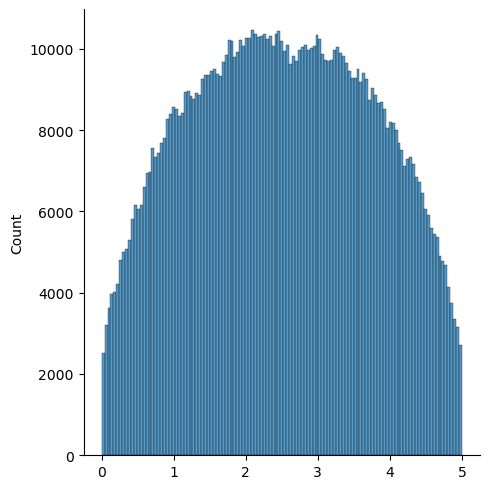

In [48]:
sns.displot(samples['alpha'].flatten())

# Exploratory analysis with posterior-argstrength (unfinished)

> **NOTE** This is copy-pasted from the analysis_variablearray.ipybn, so it might need some additional objects to work. I haven't tested it.

## Compute argstrength

This argstrength is defined as:

\begin{align}
\text{post-argstrength}^+(u)
&= \mathbb{E}_{P(\gamma \mid [\![ u ]\!] )}\left[ \gamma \right] = \int_0^1 x P(\gamma=x \mid [\![ u ]\!] ) dx
\end{align}

### Find analytic expression

where:

\begin{align}
P(\gamma \mid [\![ u ]\!] ) 
&= C P( [\![ u ]\!] \mid \gamma) P(\gamma) \\
&= C \sum_{s \in S} P( [\![ u ]\!], s \mid \gamma) P(\gamma) \\
&= C \sum_{s \in S} P( [\![ u ]\!] \mid s, \gamma) P(s \mid \gamma) P(\gamma) \\
&= C \sum_{s \in [\![ u ]\!] } P(s \mid \gamma) \\
&= C \sum_{s \in [\![ u ]\!] } \frac{\binom{N}{s_{\text{right}}}}{\prod_{i \in s} \binom{M}{i_{\text{right}}}} \gamma^{s_{\text{right}}} (1-\gamma)^{s_{\text{wrong}}}
\end{align}

Where 
- $C=\frac{1}{\int_0^1 \sum_{s \in [\![ u ]\!] } P(s \mid \gamma=x) dx}$ is the normalizing constant and assuming a uniform distribution over $\gamma$
- $s_{\text{right}}$ is the total number of right answers across all students in state $s$
- $N=s_{\text{right}}+s_{\text{wrong}}$ is the total number of questions in the exam across all students, which is the same for all utterances. 
- $M$ is the number of questions for each student.

The binomial coefficient is divided to adjusts for the difference between the probability of a sequence of binomial samples and the probability of sampling from a larger set (without the adjustment some options are counted twice).

The normalization function $C$ is:

\begin{align}
C
&= \frac{1}{\int_0^1 \sum_{s \in [\![ u ]\!] } P(s \mid \gamma=x) dx} \\
&= \frac{1}{\sum_{s \in [\![ u ]\!] } \frac{\binom{N}{s_{\text{right}}}}{\prod_{i \in s} \binom{M}{i_{\text{right}}}} \int_0^1 x^{s_{\text{right}}} (1-x)^{s_{\text{wrong}}} dx} \\
&= \frac{1}{\sum_{s \in [\![ u ]\!] } \frac{\binom{N}{s_{\text{right}}}}{\prod_{i \in s} \binom{M}{i_{\text{right}}}} \text{Beta}(s_{\text{right}}+1, s_{\text{wrong}}+1)}
\end{align}

So in conclusion:

\begin{align}
\mathbb{E}_{P(\gamma \mid [\![ u ]\!] )}\left[ \gamma \right] 
&= \int_0^1 x P(\gamma=x \mid [\![ u ]\!] ) dx \\
&= \int_0^1 x C \sum_{s \in [\![ u ]\!] } \left( \gamma^{s_{\text{right}}} (1-\gamma)^{s_{\text{wrong}}} \prod_{i \in s} \binom{M}{i_{\text{right}}} \right) dx \\
&= \frac{
    \sum_{s \in [\![ u ]\!] }\left( \text{Beta}(s_{\text{right}}+2, s_{\text{wrong}}+1) \prod_{i \in s} \binom{M}{i_{\text{right}}} \right)
}{
    \sum_{s \in [\![ u ]\!] }\left( \text{Beta}(s_{\text{right}}+1, s_{\text{wrong}}+1) \prod_{i \in s} \binom{M}{i_{\text{right}}} \right)
}\\
&= \frac{1}{N + 2} \cdot \frac{
    \sum_{s \in [\![ u ]\!]} (s_{\text{right}} + 1) E
}{
    \sum_{s \in [\![ u ]\!]} E
}
\end{align}

Where $E=\text{Beta}(s_{\text{right}} + 1, s_{\text{wrong}} + 1) \prod_{i \in s} \binom{M}{i_{\text{right}}}$

In [99]:
def compute_expected_gamma_argstrength(poss_os, possible_utterances):
    
    n_students = poss_os.shape[1]
    M = poss_os.max()
    N = n_students*M

    poss_os_right = poss_os.sum(1)
    poss_os_wrong = N - poss_os_right
    
    utterance_observation_compatibility = np.stack([
        verify(
            *a, 
            poss_os,
            n_answers=M,
            n_students=n_students
        )
        for a in possible_utterances
    ])
    
    E = beta(poss_os_right+1, poss_os_wrong+1) * binom(M, poss_os).prod(1)
    numerator = utterance_observation_compatibility @ ((poss_os_right+1)*E)
    denominator = utterance_observation_compatibility @ E

    expected_gamma_argstrength = numerator / (denominator*(N+2))
    
    return expected_gamma_argstrength

In [100]:
poss_os = list_possible_observations[0]
poss_os_right = poss_os.sum(1)
expected_gamma_argstrength = compute_expected_gamma_argstrength(
    poss_os,
    possible_utterances
)

In [88]:
expected_gamma_argstrength

array([0.97448909, 0.02551091, 0.01612903, 0.98387097, 0.01864251,
       0.98135749, 0.02551091, 0.97448909, 0.01632681, 0.98367319,
       0.97310198, 0.02689802, 0.98135191, 0.01864809, 0.98367319,
       0.01632681, 0.0162225 , 0.9837775 , 0.97391585, 0.02608415,
       0.98135498, 0.01864502, 0.9837775 , 0.0162225 , 0.01612903,
       0.98387097, 0.97448909, 0.02551091, 0.98135749, 0.01864251,
       0.98387097, 0.01612903])

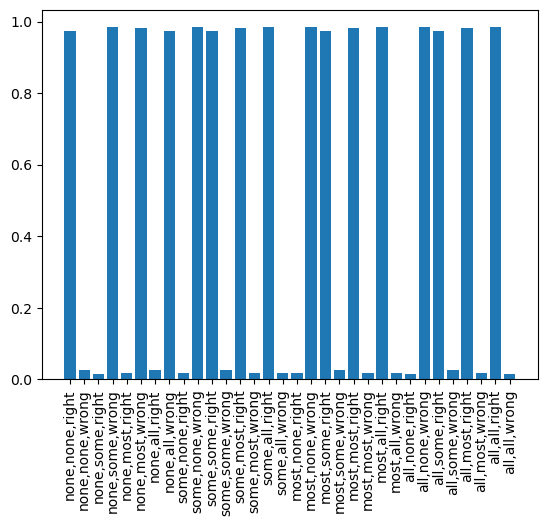

In [87]:
fig, ax = plt.subplots()
ax.bar(np.arange(len(expected_gamma_argstrength)), expected_gamma_argstrength)

ax.set_xticks(range(len(expected_gamma_argstrength)))
xlabels = [','.join(a) for a in possible_utterances]
ax.set_xticklabels(np.array(xlabels), rotation=90)
plt.show()

### Compute with approximation

\begin{align}
\mathbb{E}_{P(\gamma \mid [\![ u ]\!] )}\left[ \gamma \right] \approx \sum_{x \in \{ 0.01, 0.02, ... , 0.999\}} x P(\gamma=x \mid [\![ u ]\!] ) dx
\end{align}

where

\begin{align}
P(\gamma \mid [\![ u ]\!] ) 
&= C P( [\![ u ]\!] \mid \gamma) P(\gamma) \\
&= C \sum_{s \in S} P( [\![ u ]\!], s \mid \gamma) P(\gamma) \\
&= C \sum_{s \in S} P( [\![ u ]\!] \mid s, \gamma) P(s \mid \gamma) P(\gamma) \\
&= C \sum_{s \in [\![ u ]\!] } P(s \mid \gamma) 
\end{align}

Where $C$ is the normalizing constant and assuming a uniform distribution over $\gamma$.

In [89]:
def find_approx_exp_sigma_given_signal(grid, poss_os, possible_utterances):
    
    n_students = poss_os.shape[1]
    M = poss_os.max()
    N = n_students*M
    
    utterance_observation_compatibility = np.stack([
        verify(
            *a, 
            poss_os,
            n_answers=M,
            n_students=n_students
        )
        for a in possible_utterances
    ])

    poss_os_right = poss_os.sum(1)
    poss_os_wrong = poss_os_right.max() - poss_os_right
    
    gamma_grid = np.linspace(0,1,grid)[1:-1]

    # probability of each state (from all *possible* states) given possible values of gamma in a grid 
    p_state_given_gamma = np.exp(stats.binom.logpmf(
        poss_os,
        n=poss_os.max(), 
        p=gamma_grid[:,None,None]
    ).sum(-1)).T
        
    # get prob among the 20 states instead
    # p_state_given_gamma = p_state_given_gamma / p_state_given_gamma.sum(0)

    # for each utterance, get the sum of the probs of the states compatible with the utterance
    # (utterance, gamma grid)
    inner_sum = utterance_observation_compatibility @ p_state_given_gamma

    # normalize inner sum to get prob of each value of gamma given each utterance
    p_gamma_given_u = inner_sum / inner_sum.sum(1, keepdims=True)

    # compute expected sigma given each signal
    exp_sigma_given_signal_approx = (p_gamma_given_u * gamma_grid).sum(1)
    
    return exp_sigma_given_signal_approx

<BarContainer object of 32 artists>

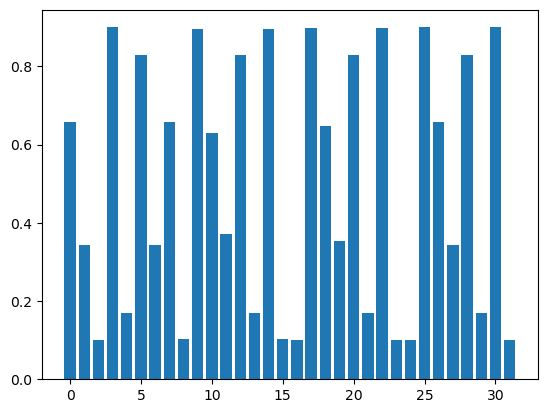

In [90]:
poss_os = list_possible_observations[0]
# poss_os = np.array(list(product(range(11), repeat=5)))
plt.bar(np.arange(32), find_approx_exp_sigma_given_signal(11, poss_os, possible_utterances))

In [92]:
deltas = []
grid_n = np.array([11, 101, 1001, 10001])
for x in grid_n:
    deltas.append(find_approx_exp_sigma_given_signal(x, poss_os, possible_utterances))
deltas = np.array(deltas)

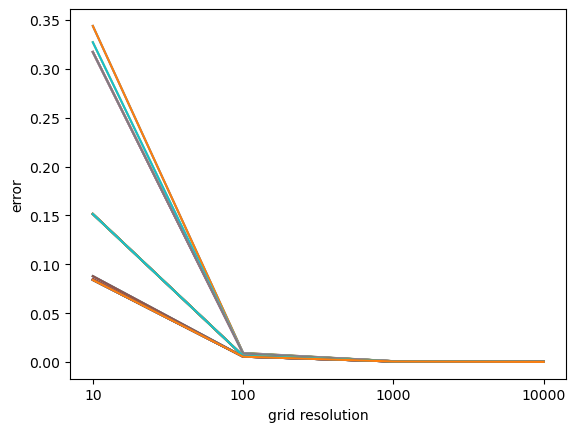

In [94]:
fig, ax = plt.subplots(1,1)
ax.plot(np.abs(deltas - expected_gamma_argstrength))
ax.set_xticks(range(len(deltas)))
ax.set_xticklabels(grid_n-1)
ax.set_ylabel('error')
ax.set_xlabel('grid resolution')
plt.show()

### Michael's code for approximation

In [23]:
import numpy as np
import math
import pandas as pd
import itertools

In [24]:
def generate_combinations_dataframe(N, M):
    """
    Generate a Pandas DataFrame with N columns (x_1, ..., x_N).
    Each row contains all combinations of integers from 0 to M for each column.
    
    ```
    # Example usage
    N = 2  # number of students
    M = 3  # number of questions
    df = generate_combinations_dataframe(N, M)
    df.head(10)  # Display the first 10 rows for brevity
    ```

    Parameters:
    N (int): Number of columns.
    M (int): Maximum integer value in each column (from 0 to M).

    Returns:
    pd.DataFrame: DataFrame containing all combinations.
    """

    # Generate column names
    column_names = [f"x_{i+1}" for i in range(N)]

    # Generate all combinations
    combinations = itertools.product(range(M + 1), repeat=N)

    # Create the DataFrame
    df = pd.DataFrame(combinations, columns=column_names)

    return df

def binomial_coeff(n, k):
    """Calculate the binomial coefficient."""
    return math.comb(n, k)

def probability(k, n, theta):
    """Calculate the binomial probability."""
    return binomial_coeff(n, k) * (theta**k) * ((1 - theta) ** (n - k))

def binomial_probability(S, N, Theta):
    """
    Calculate the joint probability of observing each count in S
    when flipping a biased coin N times with bias Theta.
    
    ```
    # Example usage
    S = [12, 9, 9, 3, 9]
    N = 12
    Theta = 0.85
    binomial_probability(S, N, Theta)
    ```

    Parameters:
    S (list): List of integer counts.
    N (int): Total number of flips.
    Theta (float): Probability of heads (success).

    Returns:
    float: The joint probability of observing each count in S.
    """

    joint_probability = 1
    for s in S:
        joint_probability *= probability(s, N, Theta)

    return joint_probability


def add_binomial_probabilities(df, total_flips, theta):
    """
    Add a column to the DataFrame containing the binomial probabilities.

    Parameters:
    df (pd.DataFrame): DataFrame with combinations of integers.
    total_flips (int): Total number of coin flips (N in binomial_probability function).
    theta (float): Probability of heads (Theta in binomial_probability function).

    Returns:
    pd.DataFrame: The updated DataFrame with a new column for binomial probabilities.
    """
    x_columns = df.filter(like="x_")

    # Define a helper function to apply to each row
    def calculate_probability(row):
        S = row.tolist()  # Convert the row to a list
        return binomial_probability(S, total_flips, theta)

    # Apply the function to each row and add the results as a new column
    df["state_prob_theta_" + str(theta)] = x_columns.apply(
        calculate_probability, axis=1
    )
    return df

def get_truth_value(S, sentence, M):
    """
    Compute truth values for a situation S, a sentence, and a
    maximum number M of successes.
    Assumes that sentences are complex (e.g., "all|most|right") or
    simple (e.g., "most|wrong").
    
    ```
    # Example usage
    sentence = "most|all|wrong"
    get_truth_value([1, 0, 0, 3, 2], sentence, 3)

    sentence = "most|wrong"
    get_truth_value([4], sentence, 10)
    ```

    Parameters:
    S (list of integers): Number of successes for each unit.
    sentence (str): Sentence in the form "most|some|right".
    M (int): Maximum possible number of successes (number of flips).

    Returns:
    TV_outer: Truth value of the sentence.
    """

    if len(sentence.split("|")) == 3:
        q_outer, q_inner, predicate = sentence.split("|")
        S = S if predicate == "right" else [M - s for s in S]
        TV_inner = [semantics[q_inner](s, M) for s in S]
        TV_outer = semantics[q_outer](sum(TV_inner), len(TV_inner))
    else:
        q_outer, predicate = sentence.split("|")
        S = S if predicate == "right" else [M - s for s in S]
        TV_outer = [semantics[q_outer](s, M) for s in S][0]

    return TV_outer

def add_semantics(df, M, all_sentences):
    """
    Add columns to the DataFrame for each element in the Cartesian product
    of quantifiers X quantifiers X predicates.
    Fill the rows for each new column with the corresponding truth-values.

    Parameters:
    df (pd.DataFrame): Input DataFrame.
    M (integer): Maximum number of successes.

    Returns:
    pd.DataFrame: The updated DataFrame.
    """
    x_columns = df.filter(like="x_")

    # Add new columns
    for sentence in all_sentences:
        column_name = "|".join(sentence)
        df[column_name] = x_columns.apply(
            lambda row: get_truth_value(row.tolist(), column_name, M), axis=1
        )

    return df


def create_lookup_situations_priors_semantics(N, M, all_sentences):

    # Generate all situation
    df_combinations = generate_combinations_dataframe(N, M)

    for i, r in enumerate(rate_grid):
        if i == 0:
            df_with_probabilities = add_binomial_probabilities(df_combinations, M, r)
        else:
            df_with_probabilities = add_binomial_probabilities(
                df_with_probabilities, M, r
            )

    # Add columns with semantics
    df = add_semantics(df_with_probabilities, M, all_sentences)

    # Add situation types
    relevant_columns = [col for col in df.columns if "|" in col]
    group_ids = df.groupby(relevant_columns).ngroup()
    df["situation_type"] = group_ids

    return df


def create_lookup_infArg(lu_sps):

    # Compute informativity
    
    ### informativity based on flat prior over situations
    filtered_columns = lu_sps.filter(regex="\|")
    informativity = filtered_columns.sum() / len(lu_sps)
    ### informativity based on flat prior over rates / world states
    situation_priors = [col for col in lu_sps if col.startswith("state_prob_theta_")]
    mean_situation_prior = lu_sps[situation_priors].mean(axis=1)
    informativity_meanRatePrior = (
        (filtered_columns.mul(mean_situation_prior, axis=0)).sum().values
    )

    # Add informativity
    infoArg_lookUp = pd.DataFrame(
        {
            "sentence": informativity.index,
            "informativity": -np.log(informativity.values),
            "informativity_meanRatePrior": -np.log(informativity_meanRatePrior),
        }
    )

    # Compute and add argStr (as expected rate)
    # semantic matrix: situation X utterance Boolean matrix of truth values
    semantic_matrix = lu_sps[[col for col in lu_sps.columns if "|" in col]].values
    # situation_prior_matrix: rate X situation row-stochastic matrix of situation probabilities (for each rate)
    situation_prior_matrix = np.transpose(
        lu_sps[[col for col in lu_sps.columns if "state_prob_theta_" in col]].values
    )
    # utterance_rate_matrix: utterance X rate row-stochastic matrix (posterior P(r | u is true))
    utterance_rate_matrix = np.transpose(
        np.dot(situation_prior_matrix * rate_prior[:, np.newaxis], semantic_matrix)
    )
    row_sums = utterance_rate_matrix.sum(axis=1)[:, np.newaxis]
    utterance_rate_matrix /= row_sums
    # argStr as expected rate parameter for each utterance
    rate_grid_np = np.array(rate_grid)
    argStrExpRate = np.sum(utterance_rate_matrix * rate_grid_np, axis=1)
    infoArg_lookUp["argStr_expRate"] = argStrExpRate
    return infoArg_lookUp

In [25]:
## define semantics, quantifiers and predicates
semantics = {
    "all": lambda x, N: int(x == N),
    "some": lambda x, N: int(x >= 1),
    "none": lambda x, N: int(x == 0),
    "most": lambda x, N: int(x > N / 2),
}
# NOTE: I changed the order of the utterances to make it the same as mine
quantifiers = ["none", "some", "most", "all"]
predicates = ["right", "wrong"]
rate_grid = [x / 10 for x in range(1, 10)]
# ground-truth prior over rates (here: just flat; but explicated for generalizability)
rate_prior = np.array([1 / len(rate_grid) for r in rate_grid])
# Cartesian product of the set of outer, inner quantifiers, and predicates
all_sentences_cmplx = itertools.product(quantifiers, quantifiers, predicates)
lu_sps = create_lookup_situations_priors_semantics(5, 10, all_sentences_cmplx)
lu_ia = create_lookup_infArg(lu_sps)

<Axes: xlabel='sentence'>

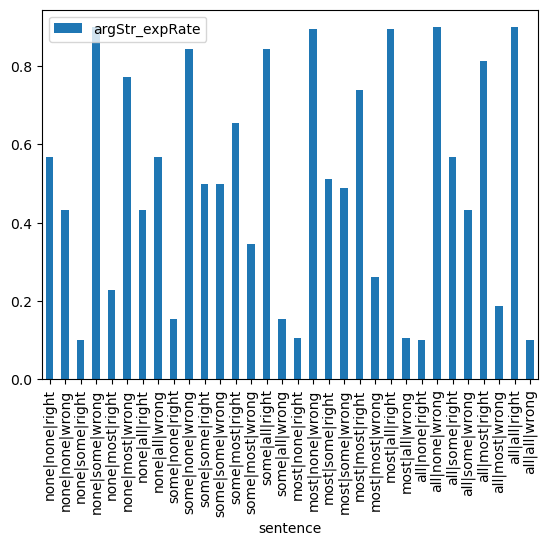

In [ ]:
lu_ia.plot(x='sentence', y='argStr_expRate', kind='bar')

### Compare Michael's approximation with formula

In [120]:
poss_os

array([[ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  2],
       ...,
       [10, 10, 10, 10,  8],
       [10, 10, 10, 10,  9],
       [10, 10, 10, 10, 10]])

In [119]:
poss_os = np.array(list(product(range(11), repeat=5)))

expected_gamma_argstrength = compute_expected_gamma_argstrength(
    poss_os,
    possible_utterances
)

expected_gamma_argstrength_approx = find_approx_exp_sigma_given_signal(
    11,
    poss_os,
    possible_utterances
)

In [96]:
df_test = pd.DataFrame({
    'sentence': ['|'.join(a) for a in possible_utterances],
    'arg_exp': expected_gamma_argstrength,
    'arg_exp_approx': expected_gamma_argstrength_approx
})

<Axes: xlabel='sentence'>

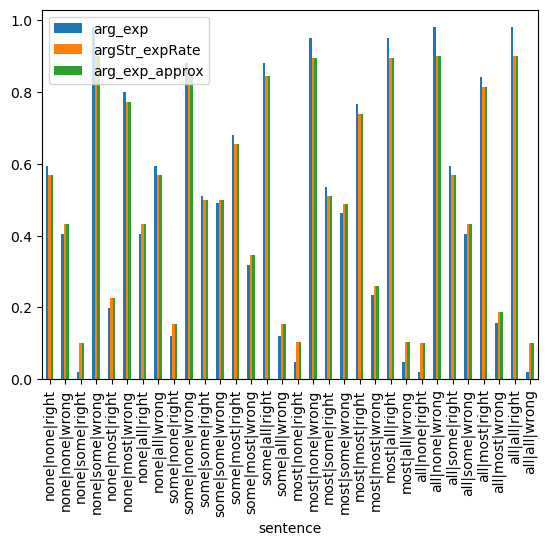

In [97]:
pd.merge(df_test, lu_ia, on='sentence')[[
    'sentence', 
    'arg_exp', 
    'argStr_expRate', 
    'arg_exp_approx'
]].plot(x='sentence', kind='bar')

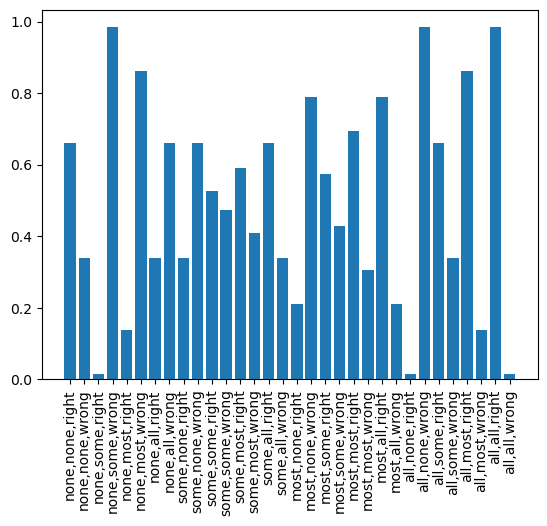

In [ ]:
fig, ax = plt.subplots()
ax.bar(np.arange(len(exp_sigma_given_signal)), exp_sigma_given_signal)

ax.set_xticks(range(len(exp_sigma_given_signal)))
xlabels = [','.join(a) for a in possible_utterances]
ax.set_xticklabels(np.array(xlabels), rotation=90)
plt.show()

## Posterior argstrength model

**Completely pooled $\alpha$ and $\beta$**

In [33]:
def factory_model_posterior_argstrength(data, list_possible_observations, 
                                 possible_utterances, include_observed=True):
                               
    mask_none = np.any(possible_utterances=='none', axis=1).astype(int)
    
    with pm.Model() as model_posterior_argstrength:

        data_utterance = pm.Data(
            'observed', 
            data['index_utterance']
        )

        alpha = pm.Uniform(
            'alpha',
            lower=0,
            upper=5,
            # one alpha per size array condition
            shape=len(list_possible_observations)
        )

        beta = pm.Uniform(
            'beta',
            lower=0,
            upper=1
        )

        cost = pm.Exponential(
            'costnone',
            lam=0.5
        )

        costs = mask_none * cost
        
        
        # define array to accumulate production probabilities
        p_production = tt.ones((
            len(possible_utterances), 
            len(data)
        ))
        
        for i, possible_observations in enumerate(list_possible_observations):

            argumentative_strengths_positive = calculate_argumentative_strength(
                possible_utterances, 
                possible_observations, 
                gamma_prove=0.85, 
                gamma_disprove=0.15,
            )
            argumentative_strengths_negative = calculate_argumentative_strength(
                possible_utterances, 
                possible_observations, 
                gamma_prove=0.15,
                gamma_disprove=0.85,
            )

            utterance_observation_compatibility = np.stack([
                verify(
                    *a, 
                    possible_observations
                )
                for a in possible_utterances
            ])

            # literal listener
            p_observation_given_utterance = normalize(
                utterance_observation_compatibility,
                1
            )
            
            p_utterance_given_observation_high = theano_calculate_pragmatic_speaker(
                p_observation_given_utterance, 
                costs,
                alpha[i],
                beta,
                argumentative_strengths_positive
            )

            p_utterance_given_observation_low = theano_calculate_pragmatic_speaker(
                p_observation_given_utterance, 
                costs,
                alpha[i], 
                beta,
                argumentative_strengths_negative
            )

            p_utterance_given_observation = tt.stack((
                p_utterance_given_observation_low,
                p_utterance_given_observation_high
            ))
            
            submask = (data['index_array_size_condition']==i).values
            
            production_probs_masked = p_utterance_given_observation[
                data.loc[submask,'condition'],
                # consider all utterances
                :,
                # set them to the corresponding 
                # production probabilities
                data.loc[submask,'index_observation']
            ].T

            p_production = tt.set_subtensor(
                p_production[
                    # all utterances
                    :,
                    # only the datapoints 
                    # in the condition of interest
                    submask
                ],
                production_probs_masked
            )

        utterances = pm.Categorical(
            'utterances',
            p_production.T,
            observed=data_utterance if include_observed else None,
            shape=len(data['index_utterance'])
        )
    
    return model_lr_argstrength

**By-participant $\alpha$, $\beta$**

In [34]:
def factory_model_lr_argstrength_hierarchical(data, list_possible_observations, 
                                              possible_utterances, include_observed=True):
    
    mask_none = np.any(possible_utterances=='none', axis=1).astype(int)

    with pm.Model() as model_lr_argstrength_hierarchical:

        data_utterance = pm.Data(
            'observed', 
            data['index_utterance']
        )

        alpha_mu = pm.Normal(
            'alpha_mu', 
            mu=0,
            sigma=1,
            # one alpha per size array condition
            shape=(len(list_possible_observations),1)
        )
        
        alpha_sigma = pm.HalfNormal(
            'alpha_sigma',
            sigma=1,
            # one alpha per size array condition
            shape=(len(list_possible_observations),1)
        )
        
        alpha_zs = pm.Normal(
            'alpha_zs',
            shape=(1,data.id.max()+1)
        )
        
        # shape (participant)
        alpha = pm.Deterministic(
            f'alpha',
            pm.math.invlogit(
                alpha_mu + 
                alpha_sigma * alpha_zs
            ) * 5
        )

        # sample the hyperparameters
        # for the beta parameter
        beta_mu = pm.Normal(
            'beta_mu', 
            mu=0,
            sigma=1
        )
        beta_sigma = pm.HalfNormal(
            'beta_sigma',
            sigma=1
        ) 
        
        beta_offset = pm.Normal(
            'beta_offset',
            # number of participants
            shape=(data.id.max()+1,)
        )
        beta = pm.Deterministic(
            'beta',
            # move from unconstrained space to constrained space
            pm.math.invlogit(beta_mu + beta_offset * beta_sigma)
        )

        cost = pm.Exponential(
            'costnone',
            lam=0.5
        )
        
        costs = mask_none * cost

        
        # define array to accumulate production probabilities
        # dimensions: (datapoint, utterance)
        p_production = tt.ones((
            len(data),
            len(possible_utterances)
        ))

        for i, possible_observations in enumerate(list_possible_observations):
            
            submask = (data['index_array_size_condition']==i).values

            p_observation_given_utterance = normalize(
                np.stack([
                    verify(
                        *a, 
                        possible_observations,
                        n_answers=possible_observations.max(),
                        n_students=possible_observations.shape[1]
                    )
                    for a in possible_utterances
                ]), 
                1
            )
            
            argumentative_strengths_positive = calculate_argumentative_strength(
                possible_utterances, 
                possible_observations, 
                gamma_prove=0.85, 
                gamma_disprove=0.15,
            )
            argumentative_strengths_negative = calculate_argumentative_strength(
                possible_utterances, 
                possible_observations, 
                gamma_prove=0.15,
                gamma_disprove=0.85,
            )
            
            p_utterance_given_observation_high = theano_calculate_pragmatic_speaker(
                p_observation_given_utterance, 
                costs,
                alpha[i],
                beta,
                argumentative_strengths_positive
            )

            p_utterance_given_observation_low = theano_calculate_pragmatic_speaker(
                p_observation_given_utterance, 
                costs,
                alpha[i], 
                beta,
                argumentative_strengths_negative
            )
            
            # dimensions: (condition, participant, utterance, observation)
            p_utterance_given_observation = tt.stack((
                p_utterance_given_observation_low,
                p_utterance_given_observation_high
            ))
                        
            production_probs_masked = p_utterance_given_observation[
                # consider high and low conditions
                data.loc[submask,'condition'],
                # index the right participant for each datapoint
                data.loc[submask, 'id'],
                # consider all utterances
                :,
                # set them to the corresponding 
                # production probabilities
                data.loc[submask,'index_observation']
            ]
            
            p_production = tt.set_subtensor(
                p_production[
                    # only the datapoints 
                    # in the condition of interest
                    submask,
                    # all utterances
                    :
                ],
                production_probs_masked
            )

        utterances = pm.Categorical(
            'utterances',
            p_production,
            observed=data_utterance if include_observed else None,
            shape=len(data['index_utterance'])
        )
    
    return model_lr_argstrength_hierarchical

# $\gamma$, $\beta$, and $\alpha$ cannot easily be jointly recovered

Details below, but in sum: At least in this version of the model, there are loads of divergences!

In [206]:
def theano_calculate_pragmatic_speaker_single(argumentative_strengths,
                                p_observation_given_utterance, costs,
                                alpha, beta):
    """
    The version of this function above (theano_calculate_pragmatic_speaker)
    considers multiple beta at once
    
    Parameters
    ----------
    argumentative_strengths: array
        Dims: (utterance)
    p_observation_given_utterance: tensor
        Dims: (utterance, observation)
    costs: tensor
        Dims: (utterance)
    beta: float
    """
    # dims: (utterance, observation)
    p_part = p_observation_given_utterance**(alpha*beta)
    
    # dims: (utterance)
    weighted_argstrength = (1-beta) * argumentative_strengths[:,None]
    
    unnorm_softmax = (
        p_part * tt.exp( alpha * ( weighted_argstrength - costs[:,None] ))
    )
    p_utterance_given_observation = theano_normalize(
        unnorm_softmax, 
        axis=0
    )

    return p_utterance_given_observation

In [211]:
def factory_model_study_identifiability(data, possible_observations, 
                                        possible_utterances, include_observed=True):

    utterance_observation_compatibility = np.stack([
        functions.verify(*a, possible_observations)
        for a in possible_utterances
    ])

    # literal listener
    p_observation_given_utterance = functions.normalize(utterance_observation_compatibility,1)
    costs = functions.get_costs(possible_utterances)
                               
    mask_none = np.any(possible_utterances=='none', axis=1).astype(int)
    
    with pm.Model() as model_study_identifiability:

        data_utterance = pm.Data(
            'observed', 
            data['index_utterance']
        )

        alpha = pm.Uniform(
            'alpha',
            lower=0,
            upper=5
        )

        beta = pm.Uniform(
            'beta',
            lower=0,
            upper=1
        )

        cost = pm.Exponential(
            'costnone',
            lam=0.5
        )
        
        mu_logit_gamma = pm.Normal("mu", 0, 2)
        sigma_logit_gamma = pm.HalfNormal("sigma", 2)
        yt_ = pm.Normal("yt", 0, 1)
        logit_gamma_positive = mu_logit_gamma + yt_ * sigma_logit_gamma
        
        gamma_positive = pm.Deterministic(
            'gamma_positive',
            pm.transforms.invlogit(logit_gamma_positive)
        )

        costs = mask_none * cost
        
        argumentative_strengths_positive = theano_calculate_argumentative_strength(
            possible_observations, 
            utterance_observation_compatibility,
            gamma_prove=gamma_positive, 
            gamma_disprove=1-gamma_positive,
        )
        
        argumentative_strengths_negative = theano_calculate_argumentative_strength(
            possible_observations, 
            utterance_observation_compatibility,
            gamma_prove=1-gamma_positive, 
            gamma_disprove=gamma_positive,
        )

        p_utterance_given_observation_high = theano_calculate_pragmatic_speaker_single(
            argumentative_strengths_positive,
            p_observation_given_utterance, 
            costs,
            alpha, 
            beta
        )

        p_utterance_given_observation_low = theano_calculate_pragmatic_speaker_single(
            argumentative_strengths_negative,
            p_observation_given_utterance, 
            costs,
            alpha, 
            beta
        )

        p_utterance_given_observation = tt.stack((
            p_utterance_given_observation_low,
            p_utterance_given_observation_high
        ))

        p_production = p_utterance_given_observation[
            data.condition,
            :, 
            data.index_observation
        ]

        utterances = pm.Categorical(
            'utterances',
            p_production,
            observed=data_utterance if include_observed else None,
            shape=len(data['index_utterance'])
        )
    
    return model_study_identifiability

In [212]:
model_study_identifiability = factory_model_study_identifiability(
    data, 
    possible_observations, 
    possible_utterances
)

In [215]:
with model_study_identifiability:
    trace_study_identifiability = pm.sample(
        draws=1000,
        tune=1000,
        # target_accept=0.99,
        return_inferencedata=True,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [yt, sigma, mu, costnone, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 124 seconds.
There were 760 divergences after tuning. Increase `target_accept` or reparameterize.
There were 720 divergences after tuning. Increase `target_accept` or reparameterize.
There were 848 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5088264356017873, but should be close to 0.8. Try to increase the number of tuning steps.
There were 779 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9089579012262836, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


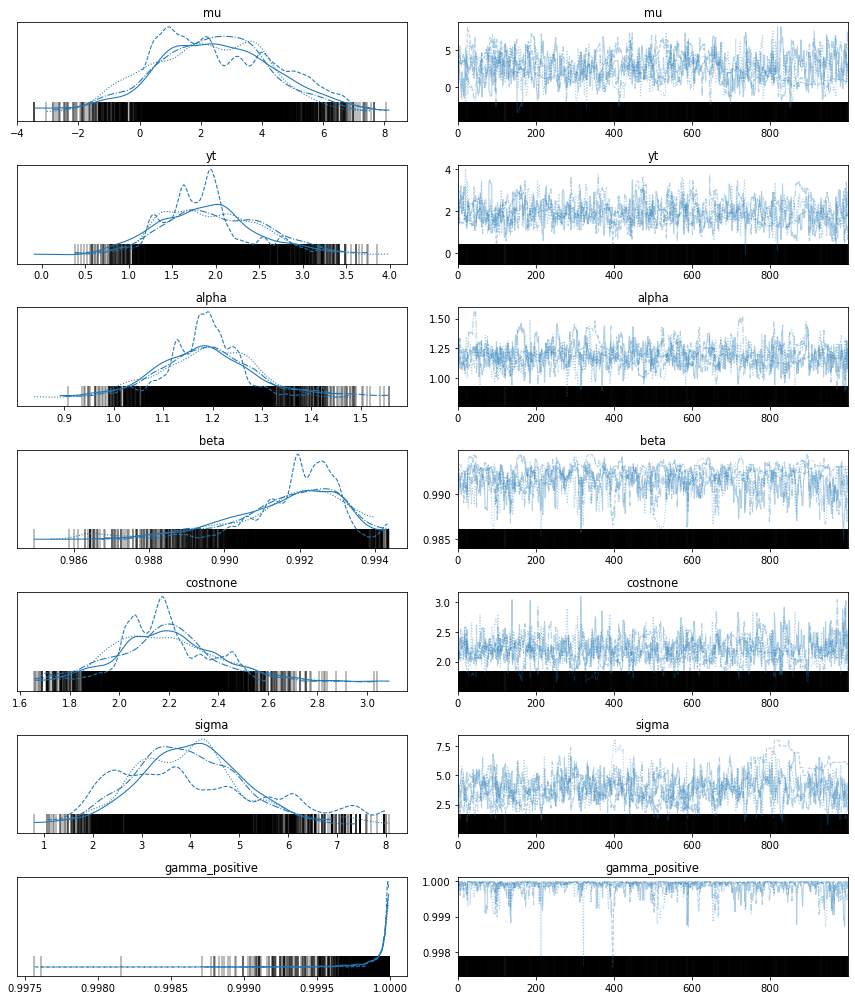

In [216]:
# run with argument strength calculated just using
# the possible observations in the experiment
az.plot_trace(trace_study_identifiability)
plt.tight_layout()
plt.show()

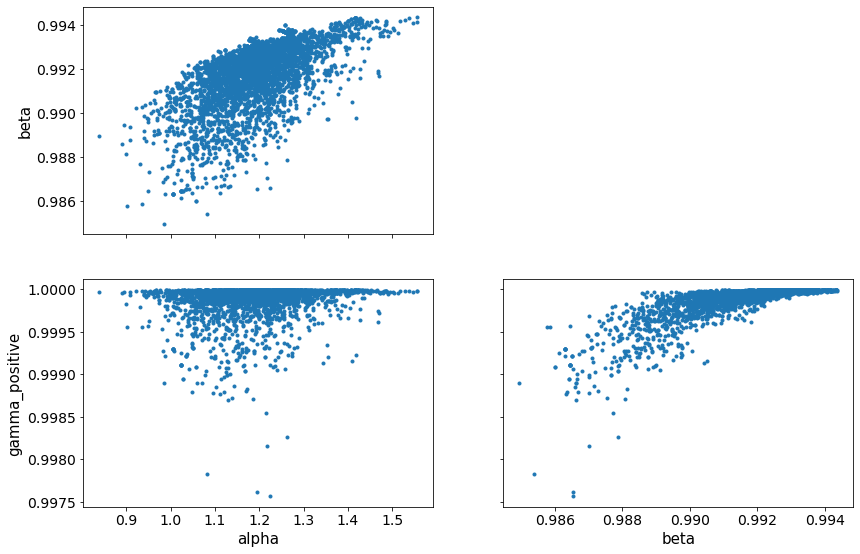

In [218]:
az.plot_pair(
    trace_study_identifiability,
    var_names=['alpha', 'beta', 'gamma_positive']
)
plt.show()

# most|most|right vs some|all|right, argumentatively

C:\Users\faust\Dropbox\Tubingen\argumentative_language\functions.py:407: RuntimeWarning: divide by zero encountered in log
  return np.log(p_prove) - np.log(p_disprove)
<ipython-input-545-24462623da05>:13: RuntimeWarning: invalid value encountered in double_scalars
  prop = arr[index_mostmostright] - arr[index_someallright]


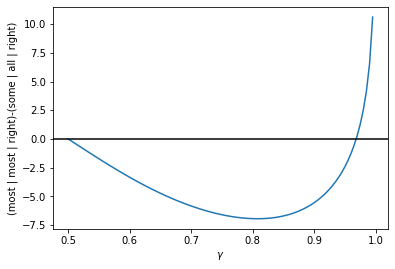

In [545]:
index_someallright = 14
index_mostmostright = 20

arr1 = []
xs = np.linspace(0.5, 1, 100)
for i in xs:
    arr = functions.calculate_argumentative_strength(
        possible_utterances, 
        possible_observations, 
        i, 
        1-i
    )
    prop = arr[index_mostmostright] - arr[index_someallright]
    arr1.append(prop)

fig, ax = plt.subplots()
ax.plot(xs, arr1)
ax.set_xlabel(r'$\gamma$')
ax.set_ylabel('(most | most | right)-(some | all | right)')
ax.axhline(c='black')